In [16]:
import control as ct
from matplotlib import pyplot as plt
import numpy as np
import sympy as sy
import os
from IPython.display import display, Math, Latex

In [17]:
# Nonlinear update function
def myvehicle_updt(t,x,u,params):
    m = params.get('m',50)
    j = params.get('j',12.5)
    c = params.get('c',.8)

    # state
    x1= x[0]
    x2= x[1]
    x3= x[2]
    x4= x[3]
    x5= x[4]
    x6= x[5]

    # input
    fx = u[0]
    fy = u[1]
    tz = u[2]



    # dynamical equation
    dx1 = x3
    dx2 = x4
    dx3 = (1/m)*fx*( np.cos(x5*(np.pi/180)) - np.sin(x5*(np.pi/180) )- c*x3 )
    dx4 = (1/m)*fy*( np.sin(x5*(np.pi/180)) + np.cos(x5*(np.pi/180) )- c*x4 )
    dx5 = x6
    dx6 = (1/j)*(tz - c*x6)

    return [dx1,dx2,dx3,dx4,dx5,dx6]

# Output function
def myvehicle_out(t, x, u, param):
    '''
    retrun Output y
    '''
    return x[0:6]

In [20]:
# Generate the Non-linear system
nonlin_myvehicle = ct.NonlinearIOSystem(myvehicle_updt, myvehicle_out, inputs=3, outputs=6, states=6 )

# find equilibrium points
u0 =np.array([0,0,0]) # no control
x0 = np.array([1,2,.5,.1,50,.1])
eqpt = ct.find_eqpt(nonlin_myvehicle,x0,u0)
xeq=eqpt[0]
sy.Matrix(xeq)

Matrix([
[    -24434.1804773791],
[     96655.9470950632],
[-5.54610704040597e-29],
[-1.49109120163933e-28],
[     10060.5345363857],
[ 3.68015461811092e-42]])

In [4]:
# Linearize the model at eq. points
lin_myvehicle = ct.linearize(nonlin_myvehicle,xeq,0)
A=lin_myvehicle.A
B=lin_myvehicle.B
C=lin_myvehicle.C
D=lin_myvehicle.D


# Pole placement
K = ct.place(A,B,[-2,-10,-8, -6, -9, -8.5])

K3=K[:,2]
K4=K[:,3]
K6=K[:,5]

K1=K[:,0]
K2=K[:,1]
K5=K[:,4]

Knew = np.array([K3,K4,K6])
Knew = np.transpose(Knew)

Kpos = np.array([K1,K2,K5])
Kpos = np.transpose(Kpos)

KI = np.zeros([3,6])
KI[:,2] = Knew[:,0]
KI[:,3] = Knew[:,1]
KI[:,5] = Knew[:,2]



#Kmat = ct.LinearIOSystem(K,inputs=6,outputs=3)

# Feedback loop
feed_lin_vehicle = ct.feedback(lin_myvehicle,K,sign=-1)



feed_nonlin_vehicle = ct.feedback(nonlin_myvehicle,K,sign=-1)

In [12]:
# Simulation param
#------------------
# Timespan
TT= np.linspace(0,100,100)
# Input array
inp = np.ones(TT.shape)

R = np.array([inp*2,inp,inp])

Rnew = Knew@R
# Initial condition
x0 = np.array([1,0,0,0,0,0])



# Response
t, y = ct.input_output_response(feed_nonlin_vehicle, TT, Kpos@R, x0)

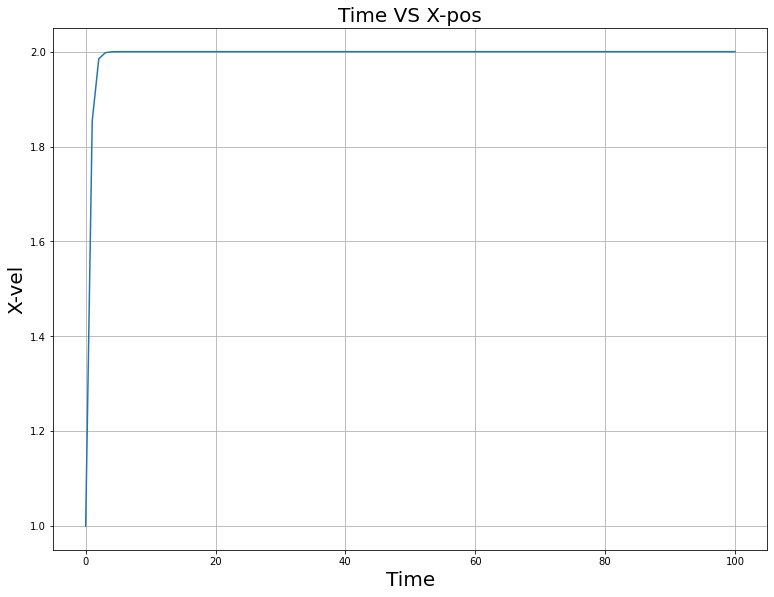

In [15]:
# Time VS X-vel
plt.figure(7,figsize=[12.8,9.6])
plt.title('Time VS X-pos', fontsize=20)
plt.plot(t,y[0])
plt.xlabel('Time',fontsize=20)
plt.ylabel('X-vel', fontsize=20)
plt.grid(True)